# Discretization of pre-processed data
## Dataset: iris
By: Sam, Malina
Update: 19/06/22

### About Dataset
Number of Instances: 150 (50 in each of three classes)
Number of Attributes: 4 numeric, predictive attributes and the class
Attribute Information:
   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class: 
      -- Iris Setosa
      -- Iris Versicolour
      -- Iris Virginica

Missing Attribute Values: None

# 1. Preparing data

In [1]:
# Import library
import pandas as pd
import numpy as np
from collections import Counter #for Chi Merge

In [2]:
# Read data
data0 = pd.read_csv('iris_data.csv', header=None)

In [3]:
data0.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
col0 = ['slength','swidth','plength','pwidth','label']

In [5]:
data0.columns = col0 # change column name

In [6]:
data0.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   slength  150 non-null    float64
 1   swidth   150 non-null    float64
 2   plength  150 non-null    float64
 3   pwidth   150 non-null    float64
 4   label    150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [7]:
data0.nunique() # Check number of distinct value for numeric attributes

slength    35
swidth     23
plength    43
pwidth     22
label       3
dtype: int64

In [8]:
# Export this dataset for discretization
data0.to_csv('clean_iris.csv',index=False)
#iris dataset
iris = data0

In [9]:
iris.columns

Index(['slength', 'swidth', 'plength', 'pwidth', 'label'], dtype='object')

In [10]:
iris.dtypes

slength    float64
swidth     float64
plength    float64
pwidth     float64
label       object
dtype: object

In [11]:
# Import label encoder
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
  
# Encode labels in column 'species'.
iris['label']= label_encoder.fit_transform(iris['label'])
  
iris['label'].unique()

array([0, 1, 2])

In [12]:
#iris= iris[['slength', 'swidth', 'plength', 'pwidth', 'label_encoded']]

In [13]:
iris

,slength,swidth,plength,pwidth,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [14]:
# Get list of attribute to discrete
#num_list = iris[['slength', 'swidth', 'plength', 'pwidth']]
#num_list = iris
# Get list of attribute to discrete
num_list = iris.columns.drop('label')
y_list = pd.DataFrame(iris['label'])
#num_list = iris.columns

In [15]:
num_list
y_list

,label
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


# 2. Chi Merge  discretization implementation 1 based on Kerber 1992
Source: https://gist.github.com/alanzchen/17d0c4a45d59b79052b1cd07f531689e

In [16]:
#Define function for chiMerge
def chimerge(data, attr, label, max_intervals):
    distinct_vals = sorted(set(data[attr])) # Sort the distinct values
    labels = sorted(set(data[label])) # Get all possible labels
    empty_count = {l: 0 for l in labels} # A helper function for padding the Counter()
    intervals = [[distinct_vals[i], distinct_vals[i]] for i in range(len(distinct_vals))] # Initialize the intervals for each attribute
    while len(intervals) > max_intervals: # While loop
        chi = []
        for i in range(len(intervals)-1):
            # Calculate the Chi2 value
            obs0 = data[data[attr].between(intervals[i][0], intervals[i][1])]
            obs1 = data[data[attr].between(intervals[i+1][0], intervals[i+1][1])]
            total = len(obs0) + len(obs1)
            count_0 = np.array([v for i, v in {**empty_count, **Counter(obs0[label])}.items()])
            count_1 = np.array([v for i, v in {**empty_count, **Counter(obs1[label])}.items()])
            count_total = count_0 + count_1
            expected_0 = count_total*sum(count_0)/total
            expected_1 = count_total*sum(count_1)/total
            chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1
            chi_ = np.nan_to_num(chi_) # Deal with the zero counts
            chi.append(sum(chi_)) # Finally do the summation for Chi2
        min_chi = min(chi) # Find the minimal Chi2 for current iteration
        for i, v in enumerate(chi):
            if v == min_chi:
                min_chi_index = i # Find the index of the interval to be merged
                break
        new_intervals = [] # Prepare for the merged new data array
        skip = False
        done = False
        for i in range(len(intervals)):
            if skip:
                skip = False
                continue
            if i == min_chi_index and not done: # Merge the intervals
                t = intervals[i] + intervals[i+1]
                new_intervals.append([min(t), max(t)])
                skip = True
                done = True
            else:
                new_intervals.append(intervals[i])
        intervals = new_intervals
    for i in intervals:
        print('[', i[0], ',', i[1], ']', sep='')
    return intervals
        

In [17]:
# REVISED FUNCTION: Mapping interval to dataframe 
def chi_map_2 (attr, data):
    disc_list = []
    for j in range(0,len(data)):
        #print('Raw value:', data[attr].loc[j])
        for i in range (0,len(chi_intervals[attr])):      
            if int(data[attr].loc[j]) in range(int(chi_intervals[attr][i][0]),int(chi_intervals[attr][i][1])):
                disc_list.append(i)
                #print('label',i)
            elif int(data[attr].loc[j]) in chi_intervals[attr][i]: # In case upper and lower are equal
                disc_list.append(i)
                #print('label',i)
    return disc_list

In [18]:
# DEBUG CHIMAP FUNCTION: Mapping interval to dataframe 
def chi_map (attr, data):
    disc_list = []
    for j in range(0,len(data)):
        #print('Raw value:', data[attr].loc[j])
        for i in range (0,len(chi_intervals[attr])):      
            if (chi_intervals[attr][i][0] <= data[attr].loc[j]) and (data[attr].loc[j] <= chi_intervals[attr][i][1]):
                disc_list.append(i)
    return disc_list

In [19]:
# #Solution 1: Convert range to int, pass input as int
# australia['A2']
# chi_intervals['A2']
# range(int(chi_intervals['A2'][0][0]),int(chi_intervals['A2'][0][1]))
# int(australia['A2'][0]) in range(int(chi_intervals['A2'][0][0]),int(chi_intervals['A2'][0][1]))


## 2.1 Chi merge with 6 intervals

In [20]:
#Chi Merge with 6 intervals
import time
start = time.time() # For measuring time execution

# Create a dictionary for saving intervals
chi_intervals = {} 
for i in num_list:
    interval = chimerge(data=iris, attr=i, label='label', max_intervals=6)
    chi_intervals[i]=interval
    
# For checking result: Get the number of intervals after chi merge discretization for each attribute
for k, v in chi_intervals.items():
    print(k)
    print(len(v)) # number of intervals
    

# Mapping original data to the intervals created 
iris_disc_6intervals = {}
for k in num_list:
    print(k)
    v = chi_map(k, iris) 
    print(v)
    iris_disc_6intervals[k]=v



C:\Users\malin\AppData\Local\Temp/ipykernel_84328/3753680822.py:19: RuntimeWarning: invalid value encountered in true_divide
  chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1


[4.3,4.8]
[4.9,4.9]
[5.0,5.4]
[5.5,5.7]
[5.8,7.0]
[7.1,7.9]
[2.0,2.2]
[2.3,2.4]
[2.5,2.8]
[2.9,2.9]
[3.0,3.3]
[3.4,4.4]
[1.0,1.9]
[3.0,4.4]
[4.5,4.7]
[4.8,4.9]
[5.0,5.1]
[5.2,6.9]
[0.1,0.6]
[1.0,1.3]
[1.4,1.6]
[1.7,1.7]
[1.8,1.8]
[1.9,2.5]
slength
6
swidth
6
plength
6
pwidth
6
slength
[2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 4, 3, 2, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 3, 1, 2, 3, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 4, 4, 4, 3, 4, 3, 4, 1, 4, 2, 2, 4, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 2, 4, 4, 4, 3, 3, 3, 4, 4, 2, 3, 3, 3, 4, 2, 3, 4, 4, 5, 4, 4, 5, 1, 5, 4, 5, 4, 4, 4, 3, 4, 4, 4, 5, 5, 4, 4, 3, 5, 4, 4, 5, 4, 4, 4, 5, 5, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
swidth
[5, 4, 4, 4, 5, 5, 5, 5, 3, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 4, 4, 5, 5, 5, 4, 4, 5, 4, 4, 5, 5, 1, 4, 5, 5, 4, 5, 4, 5, 4, 4, 4, 4, 1, 2, 2, 4, 1, 3, 2, 0, 4, 0, 3, 3, 4, 4, 2, 0, 2, 4, 2, 2, 2, 3, 4, 2, 4, 3, 2, 1, 1, 2, 2, 4, 

In [21]:
# Convert the discrete output to dataframe.
# For training, need to merge the label column of the original dataframe to this one
iris_disc_6intervals = pd.DataFrame.from_dict(iris_disc_6intervals)

iris_disc_6intervals.head()

end = time.time()
print(end - start) # Total time execution for this sample

1.8791050910949707


In [22]:
tmp = pd.concat([iris_disc_6intervals,y_list], axis=1)
tmp
# Export this dataset for discretization
#convert to csv file
tmp.to_csv('chim_iris_6int.csv',index=False)

In [23]:
tmp

,slength,swidth,plength,pwidth,label
0,2,5,0,0,0
1,1,4,0,0,0
2,0,4,0,0,0
3,0,4,0,0,0
4,2,5,0,0,0
...,...,...,...,...,...
145,4,4,5,5,2
146,4,2,4,5,2
147,4,4,5,5,2
148,4,5,5,5,2


In [24]:
#Chi Merge with 6 intervals
import time
start = time.time() # For measuring time execution

# Create a dictionary for saving intervals
chi_intervals = {} 
for i in num_list:
    interval = chimerge(data=iris, attr=i, label='label', max_intervals=6)
    chi_intervals[i]=interval
    
# For checking result: Get the number of intervals after chi merge discretization for each attribute
for k, v in chi_intervals.items():
    print(k)
    print(len(v)) # number of intervals
    

# Mapping original data to the intervals created
iris_disc_6intervals = {}
for k in num_list:
    print(k)
    v = chi_map(k, iris)
    print(v)
    iris_disc_6intervals[k]=v


# Convert the discrete output to dataframe.
# For training, need to merge the label column of the original dataframe to this one
iris_disc_6intervals = pd.DataFrame.from_dict(iris_disc_6intervals)

iris_disc_6intervals.head(10)

end = time.time()
print(end - start) # Total time execution for this sample

#convert to csv file

C:\Users\malin\AppData\Local\Temp/ipykernel_84328/3753680822.py:19: RuntimeWarning: invalid value encountered in true_divide
  chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1


[4.3,4.8]
[4.9,4.9]
[5.0,5.4]
[5.5,5.7]
[5.8,7.0]
[7.1,7.9]
[2.0,2.2]
[2.3,2.4]
[2.5,2.8]
[2.9,2.9]
[3.0,3.3]
[3.4,4.4]
[1.0,1.9]
[3.0,4.4]
[4.5,4.7]
[4.8,4.9]
[5.0,5.1]
[5.2,6.9]
[0.1,0.6]
[1.0,1.3]
[1.4,1.6]
[1.7,1.7]
[1.8,1.8]
[1.9,2.5]
slength
6
swidth
6
plength
6
pwidth
6
slength
[2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 4, 3, 2, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 3, 1, 2, 3, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 4, 4, 4, 3, 4, 3, 4, 1, 4, 2, 2, 4, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, 2, 4, 4, 4, 3, 3, 3, 4, 4, 2, 3, 3, 3, 4, 2, 3, 4, 4, 5, 4, 4, 5, 1, 5, 4, 5, 4, 4, 4, 3, 4, 4, 4, 5, 5, 4, 4, 3, 5, 4, 4, 5, 4, 4, 4, 5, 5, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
swidth
[5, 4, 4, 4, 5, 5, 5, 5, 3, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5, 5, 4, 4, 5, 5, 5, 4, 4, 5, 4, 4, 5, 5, 1, 4, 5, 5, 4, 5, 4, 5, 4, 4, 4, 4, 1, 2, 2, 4, 1, 3, 2, 0, 4, 0, 3, 3, 4, 4, 2, 0, 2, 4, 2, 2, 2, 3, 4, 2, 4, 3, 2, 1, 1, 2, 2, 4, 

## 2.2 ChiMerge with 8 Intervals

In [25]:
#Chi Merge with 8 intervals
import time
start = time.time() # For measuring time execution

# Create a dictionary for saving intervals
chi_intervals = {} 
for i in num_list:
    interval = chimerge(data=iris, attr=i, label='label', max_intervals=8)
    chi_intervals[i]=interval
    
# For checking result: Get the number of intervals after chi merge discretization for each attribute
for k, v in chi_intervals.items():
    print(k)
    print(len(v)) # number of intervals
    

# Mapping original data to the intervals created
iris_disc_8intervals = {}
for k in num_list:
    print(k)
    v = chi_map(k, iris)
    print(v)
    iris_disc_8intervals[k]=v


# Convert the discrete output to dataframe.
# For training, need to merge the label column of the original dataframe to this one
iris_disc_8intervals = pd.DataFrame.from_dict(iris_disc_8intervals)

iris_disc_8intervals.head(10)

end = time.time()
print(end - start) # Total time execution for this sample

#convert to csv file

C:\Users\malin\AppData\Local\Temp/ipykernel_84328/3753680822.py:19: RuntimeWarning: invalid value encountered in true_divide
  chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1


[4.3,4.8]
[4.9,4.9]
[5.0,5.4]
[5.5,5.7]
[5.8,5.8]
[5.9,6.2]
[6.3,7.0]
[7.1,7.9]
[2.0,2.2]
[2.3,2.4]
[2.5,2.8]
[2.9,2.9]
[3.0,3.3]
[3.4,3.5]
[3.6,3.8]
[3.9,4.4]
[1.0,1.9]
[3.0,4.4]
[4.5,4.5]
[4.6,4.7]
[4.8,4.9]
[5.0,5.0]
[5.1,5.1]
[5.2,6.9]
[0.1,0.6]
[1.0,1.3]
[1.4,1.4]
[1.5,1.5]
[1.6,1.6]
[1.7,1.7]
[1.8,1.8]
[1.9,2.5]
slength
8
swidth
8
plength
8
pwidth
8
slength
[2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 4, 3, 2, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 3, 1, 2, 3, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 6, 6, 6, 3, 6, 3, 6, 1, 6, 2, 2, 5, 5, 5, 3, 6, 3, 4, 5, 3, 5, 5, 6, 5, 6, 6, 6, 6, 5, 3, 3, 3, 4, 5, 2, 5, 6, 6, 3, 3, 3, 5, 4, 2, 3, 3, 3, 5, 2, 3, 6, 4, 7, 6, 6, 7, 1, 7, 6, 7, 6, 6, 6, 3, 4, 6, 6, 7, 7, 5, 6, 3, 7, 6, 6, 7, 5, 5, 6, 7, 7, 7, 6, 6, 5, 7, 6, 6, 5, 6, 6, 6, 4, 6, 6, 6, 6, 6, 5, 5]
swidth
[5, 4, 4, 4, 6, 7, 5, 5, 3, 4, 6, 5, 4, 4, 7, 7, 7, 5, 6, 6, 5, 6, 6, 4, 5, 4, 5, 5, 5, 4, 4, 5, 7, 7, 4, 4, 5, 4, 4, 5, 5, 1, 4, 5, 6, 4, 6, 4, 6, 4, 4, 4, 4, 1, 2, 2, 4, 1, 3

In [26]:
tmp = pd.concat([iris_disc_8intervals,y_list], axis=1)
tmp
# Export this dataset for discretization
#convert to csv file
tmp.to_csv('chim_iris_8int.csv',index=False)

## 2.3 ChiMerge with 10 Intervals

In [27]:
#Chi Merge with 10 intervals
import time
start = time.time() # For measuring time execution

# Create a dictionary for saving intervals
chi_intervals = {} 
for i in num_list:
    interval = chimerge(data=iris, attr=i, label='label', max_intervals=10)
    chi_intervals[i]=interval
    
# For checking result: Get the number of intervals after chi merge discretization for each attribute
for k, v in chi_intervals.items():
    print(k)
    print(len(v)) # number of intervals
    

# Mapping original data to the intervals created (sample size = 50)
iris_disc_10intervals = {}
for k in num_list:
    print(k)
    v = chi_map(k, iris) # musk 50: sample data
    print(v)
    iris_disc_10intervals[k]=v


# Convert the discrete output to dataframe.
# For training, need to merge the label column of the original dataframe to this one
iris_disc_10intervals = pd.DataFrame.from_dict(iris_disc_10intervals)

iris_disc_10intervals.head(10)

end = time.time()
print(end - start) # Total time execution for this sample

#convert to csv file

C:\Users\malin\AppData\Local\Temp/ipykernel_84328/3753680822.py:19: RuntimeWarning: invalid value encountered in true_divide
  chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1


[4.3,4.8]
[4.9,4.9]
[5.0,5.4]
[5.5,5.7]
[5.8,5.8]
[5.9,6.2]
[6.3,6.5]
[6.6,6.6]
[6.7,7.0]
[7.1,7.9]
[2.0,2.2]
[2.3,2.4]
[2.5,2.8]
[2.9,2.9]
[3.0,3.0]
[3.1,3.3]
[3.4,3.4]
[3.5,3.5]
[3.6,3.8]
[3.9,4.4]
[1.0,1.9]
[3.0,4.4]
[4.5,4.5]
[4.6,4.7]
[4.8,4.8]
[4.9,4.9]
[5.0,5.0]
[5.1,5.1]
[5.2,6.7]
[6.9,6.9]
[0.1,0.6]
[1.0,1.3]
[1.4,1.4]
[1.5,1.5]
[1.6,1.6]
[1.7,1.7]
[1.8,1.8]
[1.9,2.3]
[2.4,2.4]
[2.5,2.5]
slength
10
swidth
10
plength
10
pwidth
10
slength
[2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 4, 3, 2, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 3, 1, 2, 3, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 8, 6, 8, 3, 6, 3, 6, 1, 7, 2, 2, 5, 5, 5, 3, 8, 3, 4, 5, 3, 5, 5, 6, 5, 6, 7, 8, 8, 5, 3, 3, 3, 4, 5, 2, 5, 8, 6, 3, 3, 3, 5, 4, 2, 3, 3, 3, 5, 2, 3, 6, 4, 9, 6, 6, 9, 1, 9, 8, 9, 6, 6, 8, 3, 4, 6, 6, 9, 9, 5, 8, 3, 9, 6, 8, 9, 5, 5, 6, 9, 9, 9, 6, 6, 5, 9, 6, 6, 5, 8, 8, 8, 4, 8, 8, 8, 6, 6, 5, 5]
swidth
[7, 4, 5, 5, 8, 9, 6, 6, 3, 5, 8, 6, 4, 4, 9, 9, 9, 7, 8, 8, 6, 8, 8, 5, 6, 4, 6, 7, 6, 5, 5

In [28]:
tmp = pd.concat([iris_disc_10intervals,y_list], axis=1)
tmp
# Export this dataset for discretization
#convert to csv file
tmp.to_csv('chim_iris_10int.csv',index=False)

In [29]:
tmp

,slength,swidth,plength,pwidth,label
0,2,7,0,0,0
1,1,4,0,0,0
2,0,5,0,0,0
3,0,5,0,0,0
4,2,8,0,0,0
...,...,...,...,...,...
145,8,4,8,7,2
146,6,2,6,7,2
147,6,4,8,7,2
148,5,6,8,7,2


## 2.4 ChiMerge with 15 Intervals

In [30]:
#Chi Merge with 15 intervals
import time
start = time.time() # For measuring time execution

# Create a dictionary for saving intervals
chi_intervals = {} 
for i in num_list:
    interval = chimerge(data=iris, attr=i, label='label', max_intervals=15)
    chi_intervals[i]=interval
    
# For checking result: Get the number of intervals after chi merge discretization for each attribute
for k, v in chi_intervals.items():
    print(k)
    print(len(v)) # number of intervals
    

# Mapping original data to the intervals created
iris_disc_15intervals = {}
for k in num_list:
    print(k)
    v = chi_map(k, iris) 
    print(v)
    iris_disc_15intervals[k]=v


# Convert the discrete output to dataframe.
# For training, need to merge the label column of the original dataframe to this one
iris_disc_15intervals = pd.DataFrame.from_dict(iris_disc_15intervals)

iris_disc_15intervals.head(10)

end = time.time()
print(end - start) # Total time execution for this sample

#convert to csv file

C:\Users\malin\AppData\Local\Temp/ipykernel_84328/3753680822.py:19: RuntimeWarning: invalid value encountered in true_divide
  chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1


[4.3,4.8]
[4.9,4.9]
[5.0,5.4]
[5.5,5.5]
[5.6,5.6]
[5.7,5.7]
[5.8,5.8]
[5.9,6.1]
[6.2,6.2]
[6.3,6.4]
[6.5,6.5]
[6.6,6.6]
[6.7,6.9]
[7.0,7.0]
[7.1,7.9]
[2.0,2.0]
[2.2,2.2]
[2.3,2.3]
[2.4,2.4]
[2.5,2.7]
[2.8,2.8]
[2.9,2.9]
[3.0,3.0]
[3.1,3.3]
[3.4,3.4]
[3.5,3.5]
[3.6,3.6]
[3.7,3.7]
[3.8,3.8]
[3.9,4.4]
[1.0,1.9]
[3.0,4.4]
[4.5,4.5]
[4.6,4.7]
[4.8,4.8]
[4.9,4.9]
[5.0,5.0]
[5.1,5.1]
[5.2,6.0]
[6.1,6.1]
[6.3,6.3]
[6.4,6.4]
[6.6,6.6]
[6.7,6.7]
[6.9,6.9]
[0.1,0.6]
[1.0,1.2]
[1.3,1.3]
[1.4,1.4]
[1.5,1.5]
[1.6,1.6]
[1.7,1.7]
[1.8,1.8]
[1.9,1.9]
[2.0,2.0]
[2.1,2.1]
[2.2,2.2]
[2.3,2.3]
[2.4,2.4]
[2.5,2.5]
slength
15
swidth
15
plength
15
pwidth
15
slength
[2, 1, 0, 0, 2, 2, 0, 2, 0, 1, 2, 0, 0, 0, 6, 5, 2, 2, 5, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 3, 1, 2, 3, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 13, 9, 12, 3, 10, 5, 9, 1, 11, 2, 2, 7, 7, 7, 4, 12, 4, 6, 8, 4, 7, 7, 9, 7, 9, 11, 12, 12, 7, 5, 3, 3, 6, 7, 2, 7, 12, 9, 4, 3, 3, 7, 6, 2, 4, 5, 5, 8, 2, 5, 9, 6, 14, 9, 10, 14, 1, 14, 12, 14, 10, 

In [31]:
tmp = pd.concat([iris_disc_15intervals,y_list], axis=1)
tmp
# Export this dataset for discretization
#convert to csv file
tmp.to_csv('chim_iris_15int.csv',index=False)

In [32]:
tmp

,slength,swidth,plength,pwidth,label
0,2,10,0,0,0
1,1,7,0,0,0
2,0,8,0,0,0
3,0,8,0,0,0
4,2,11,0,0,0
...,...,...,...,...,...
145,12,7,8,12,2
146,9,4,6,8,2
147,10,7,8,9,2
148,8,9,8,12,2


# 3. Decision Tree discretization

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from feature_engine.discretisation import DecisionTreeDiscretiser

In [34]:
# Load dataset
data = iris
data

,slength,swidth,plength,pwidth,label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [35]:
data.columns

Index(['slength', 'swidth', 'plength', 'pwidth', 'label'], dtype='object')

In [36]:


# Separate into train and test sets
#X_train, X_test, y_train, y_test =  train_test_split(
#            data.drop(['Id', 'SalePrice'], axis=1),
#            data['SalePrice'], test_size=0.3, random_state=0)

# Separate into train and test sets
X_train, X_test, y_train, y_test =  train_test_split(
            data,
            data['label'], test_size=0.3, random_state=0)

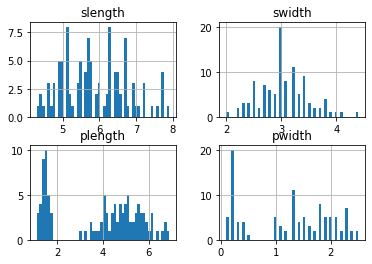

In [37]:
# we will discretise 4 continuous variables
# Visualization pre-discretization

X_train[['slength', 'swidth', 'plength', 'pwidth']].hist(bins=50)
plt.show()

In [38]:
'''
Parameters
----------

cv : int, default=3
    Desired number of cross-validation fold to be used to fit the decision
    tree.

scoring: str, default='neg_mean_squared_error'
    Desired metric to optimise the performance for the tree. Comes from
    sklearn metrics. See DecisionTreeRegressor or DecisionTreeClassifier
    model evaluation documentation for more options:
    https://scikit-learn.org/stable/modules/model_evaluation.html

variables : list
    The list of numerical variables that will be transformed. If None, the
    discretiser will automatically select all numerical type variables.

regression : boolean, default=True
    Indicates whether the discretiser should train a regression or a classification
    decision tree.

param_grid : dictionary, default=None
    The list of parameters over which the decision tree should be optimised
    during the grid search. The param_grid can contain any of the permitted
    parameters for Scikit-learn's DecisionTreeRegressor() or
    DecisionTreeClassifier().

    If None, then param_grid = {'max_depth': [1, 2, 3, 4]}

random_state : int, default=None
    The random_state to initialise the training of the decision tree. It is one
    of the parameters of the Scikit-learn's DecisionTreeRegressor() or
    DecisionTreeClassifier(). For reproducibility it is recommended to set
    the random_state to an integer.
'''
#For DT using regression
#treeDisc = DecisionTreeDiscretiser(cv=3,
 #                                  scoring='neg_mean_squared_error',
 #                                  variables=['recency', 'frequency', 'monetary', 'time'],
 #                                  regression=False,
 #                                  random_state=29)
#regression = True!

# the DecisionTreeDiscretiser needs the target for fitting
#treeDisc.fit(X_train, y_train)


treeDisc = DecisionTreeDiscretiser(cv=3,
                                   scoring='accuracy',
                                   variables=['slength', 'swidth', 'plength', 'pwidth'],
                                   regression=False,
                                   param_grid={'max_depth': [5, 20]},
                                   random_state=29,
                                   )

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(param_grid={'max_depth': [5, 20]}, random_state=29,
                        regression=False, scoring='accuracy',
                        variables=['slength', 'swidth', 'plength', 'pwidth'])

In [39]:
treeDisc.binner_dict_


{'slength': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=29),
              param_grid={'max_depth': [5, 20]}, scoring='accuracy'),
 'swidth': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=29),
              param_grid={'max_depth': [5, 20]}, scoring='accuracy'),
 'plength': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=29),
              param_grid={'max_depth': [5, 20]}, scoring='accuracy'),
 'pwidth': GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=29),
              param_grid={'max_depth': [5, 20]}, scoring='accuracy')}

In [40]:
treeDisc.scores_dict_

{'slength': 0.8095238095238095,
 'swidth': 0.6,
 'plength': 0.9619047619047619,
 'pwidth': 0.9523809523809523}

In [41]:
train_t = treeDisc.transform(X_train)
test_t = treeDisc.transform(X_test)

In [42]:
# here I put side by side the original variable and the transformed variable
tmp = pd.concat([X_train[['slength', 'swidth','plength', 'pwidth', 'label']],
                 train_t[['slength', 'swidth','plength', 'pwidth', 'label']]], axis=1)

tmp.columns = ['slength', 'swidth','plength', 'pwidth', 'label',
               'slength_binned', 'swidth_binned','plength_binned', 'pwidth_binned','label']

tmp

,slength,swidth,plength,pwidth,label,slength_binned,swidth_binned,plength_binned,pwidth_binned,label
60,5.0,2.0,3.5,1.0,1,0.200000,1.000000,1.00,1.000,1
116,6.5,3.0,5.5,1.8,2,0.000000,0.250000,0.00,0.125,2
144,6.7,3.3,5.7,2.5,2,0.285714,0.200000,0.00,0.000,2
119,6.0,2.2,5.0,1.5,2,0.333333,0.500000,0.25,0.600,2
108,6.7,2.5,5.8,1.8,2,0.285714,0.470588,0.00,0.125,2
...,...,...,...,...,...,...,...,...,...,...
9,4.9,3.1,1.5,0.1,0,0.200000,0.250000,0.00,0.000,0
103,6.3,2.9,5.6,1.8,2,0.375000,0.800000,0.00,0.125,2
67,5.8,2.7,4.1,1.0,1,0.400000,0.470588,1.00,1.000,1
117,7.7,3.8,6.7,2.2,2,0.000000,0.000000,0.00,0.000,2


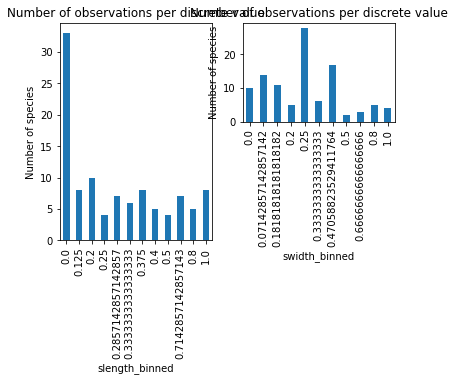

In [43]:
plt.subplot(1, 2, 1)
tmp.groupby('slength_binned')['slength'].count().plot.bar()
plt.ylabel('Number of species')
plt.title('Number of observations per discrete value')

plt.subplot(2, 2, 2)
tmp.groupby('swidth_binned')['swidth'].count().plot.bar()
plt.ylabel('Number of species')
plt.title('Number of observations per discrete value')

plt.show()


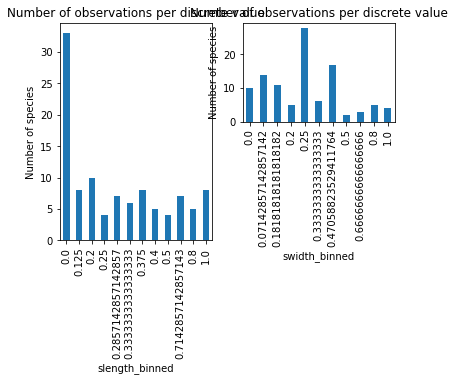

In [44]:
plt.subplot(1, 2, 1)
tmp.groupby('slength_binned')['slength'].count().plot.bar()
plt.ylabel('Number of species')
plt.title('Number of observations per discrete value')

plt.subplot(2, 2, 2)
tmp.groupby('swidth_binned')['swidth'].count().plot.bar()
plt.ylabel('Number of species')
plt.title('Number of observations per discrete value')

plt.show()


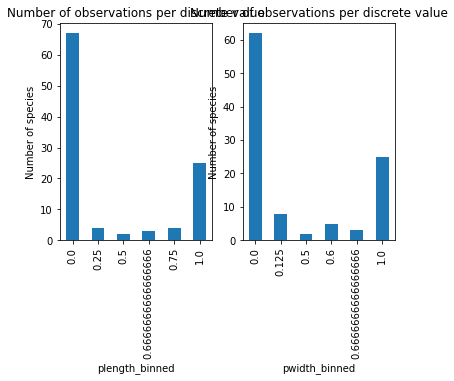

In [45]:
plt.subplot(1, 2, 1)
tmp.groupby('plength_binned')['plength'].count().plot.bar()
plt.ylabel('Number of species')
plt.title('Number of observations per discrete value')

plt.subplot(1, 2, 2)
tmp.groupby('pwidth_binned')['pwidth'].count().plot.bar()
plt.ylabel('Number of species')
plt.title('Number of observations per discrete value')

plt.show()


In [46]:
tmp = tmp[['slength_binned', 'swidth_binned','plength_binned', 'pwidth_binned','label']]
tmp
# Export this dataset for  classification
tmp.to_csv('DT_discretized_iris.csv',index=False)